# Analysis of Orders/Visits Data

# Description: 
    - First objective is to clean to data, making it ready for further analysis.
    - We checked for missing values and duplicate rows, followed by removing all the 'visitorId' with more than 1 group.
    - Calculated the ICE and RICE for all the hypotheses.
    - Made statistical comparison between both groups in following categories: a) number of orders per user b) order prices.
    - Calculated the percentiles for the above categories.
    - Calculated the statistical significance of conversion rate and average order size for both groups.
    - Identified anomolies in the data, and repeated analysis after correction of anomolies.
    
# Purspose:
    - To prioritize the hypotheses.
    - To identify a difference in conversion rate and average order size between the groups. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math

In [2]:
hypotheses = pd.read_csv('../Sprint_10/hypotheses_us.csv', sep=';')
orders = pd.read_csv('../Sprint_10/orders_us.csv',
                     dtype = {'group': 'category'},
                     parse_dates = ['date'])
visits = pd.read_csv('../Sprint_10/visits_us.csv',
                     dtype = {'group': 'category'},
                     parse_dates = ['date'])

In [3]:
hypotheses.info()
print()
orders.info()
print()
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 38.8 KB

<class 'pandas.co

In [4]:
print(orders.isna().sum())
print()
print(visits.isna().sum())

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

date      0
group     0
visits    0
dtype: int64


In [5]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())

0
0


In [6]:
group_count = orders.groupby('visitorId').agg({'group':'nunique'}).reset_index()
group_count.columns = ['visitorId', 'group_count']
print(orders.shape)
orders=pd.merge(orders, group_count, on = 'visitorId')
print(orders.shape)
orders = orders[orders['group_count']<2]
print(orders.shape)

(1197, 5)
(1197, 6)
(1016, 6)


#### conclusion:
    - visitorIds with in more than 1 group were removed to clean the data.
    - .isna() & .duplciated() revealed no missing values or duplicate data.

## Part 1. Prioritizing Hypotheses

In [7]:
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [8]:
hypotheses['ICE'] = round((hypotheses['Impact']*hypotheses['Confidence'])/hypotheses['Effort'], 2)
hypotheses['RICE'] = (hypotheses['Reach']*hypotheses['Impact']*hypotheses['Confidence'])/hypotheses['Effort']
pd.set_option('display.max_colwidth', 1000)
display(hypotheses[['Hypothesis','ICE']].sort_values('ICE', ascending =False))
display(hypotheses[['Hypothesis','RICE']].sort_values('RICE', ascending =False))

,Hypothesis,ICE
8,Launch a promotion that gives users discounts on their birthdays,16.20
0,Add two new channels for attracting traffic. This will bring 30% more users,13.33
7,Add a subscription form to all the main pages. This will help you compile a mailing list,11.20
6,Show banners with current offers and sales on the main page. This will boost conversion,8.00
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,7.00
1,Launch your own delivery service. This will shorten delivery time,2.00
5,Add a customer review page. This will increase the number of orders,1.33
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,1.12
4,Change the background color on the main page. This will increase user engagement,1.00


,Hypothesis,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,40.0
8,Launch a promotion that gives users discounts on their birthdays,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,9.0
1,Launch your own delivery service. This will shorten delivery time,4.0
5,Add a customer review page. This will increase the number of orders,4.0
4,Change the background color on the main page. This will increase user engagement,3.0


In [9]:
display(hypotheses['Reach'])

0     3
1     2
2     8
3     8
4     3
5     3
6     5
7    10
8     1
Name: Reach, dtype: int64

#### Conclusion:
    - Reach has a significant effect on prioritizing hypothesis.
    - Hypotheses 2,3 & 7 all have high Reach.
    - These Hypotheses also have significantly better RICE compared to ICE.

## Part 2. A/B Test Analysis

### Graph cumulative revenue by group. 

In [10]:
orders_A = orders[orders['group']== 'A']
orders_A = orders_A.groupby('date').agg({'revenue':'sum', 'group_count': 'count'}).reset_index()
orders_A = orders_A.sort_values('date')
orders_A.columns =['date', 'revenue', 'orders']

orders_B = orders[orders['group']== 'B']
orders_B = orders_B.groupby('date').agg({'revenue':'sum', 'group_count': 'count'}).reset_index()
orders_B = orders_B.sort_values('date')
orders_B.columns =['date', 'revenue', 'orders']

In [11]:
orders_A['cuml_rev'] = orders_A['revenue'].cumsum()
orders_B['cuml_rev'] = orders_B['revenue'].cumsum()

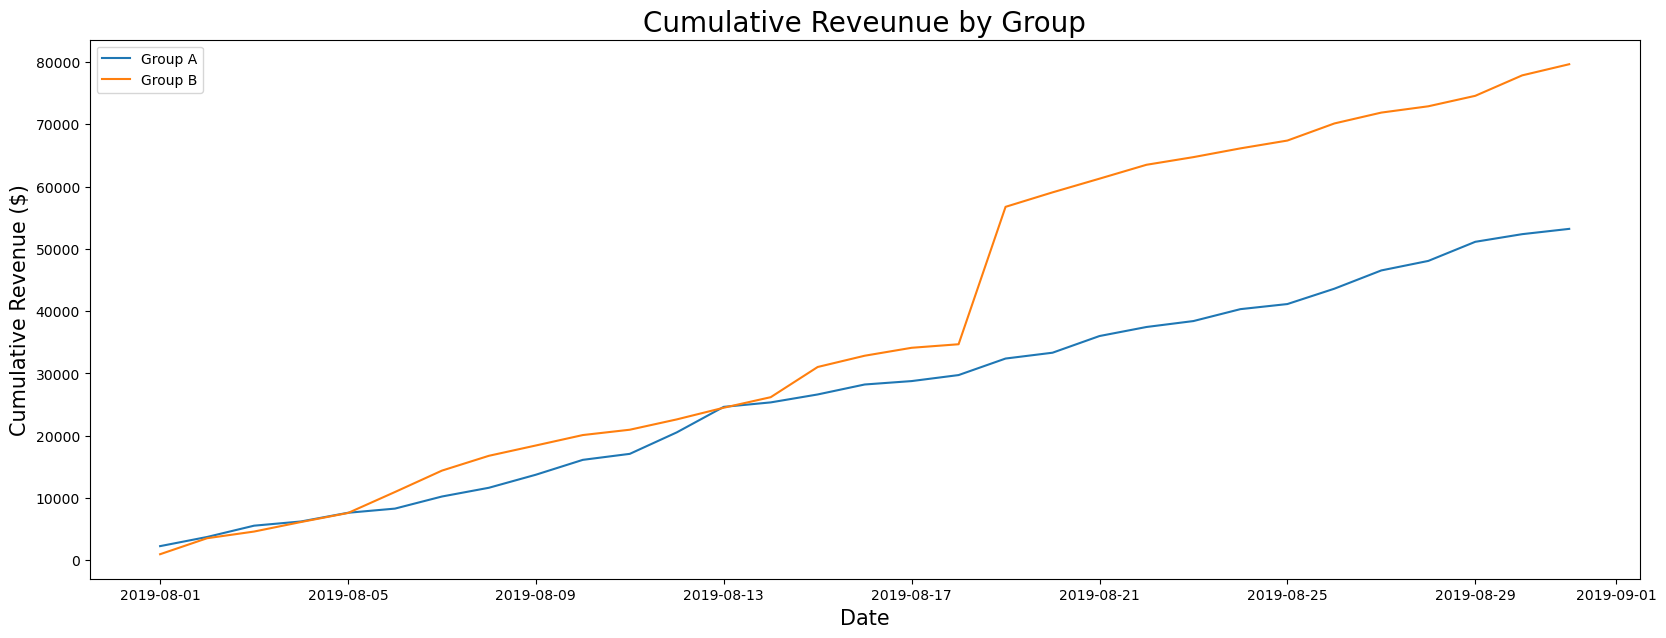

In [12]:
plt.figure(figsize = (20,7))
plt.plot(orders_A['date'], orders_A['cuml_rev'], label = 'Group A')
plt.plot(orders_B['date'], orders_B['cuml_rev'], label = 'Group B')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Cumulative Revenue ($)', fontsize = 15)
plt.title('Cumulative Reveunue by Group', fontsize = 20)
plt.legend()
plt.show()

#### Conclusion:
    - Cumulative revenue seems to be higher for Group B.

### Graph cumulative average order size by group.

In [13]:
orders_A['cuml_orders'] = orders_A['orders'].cumsum()
orders_A['cuml_avg_order_size'] = orders_A['cuml_rev']/orders_A['cuml_orders']

orders_B['cuml_orders'] = orders_B['orders'].cumsum()
orders_B['cuml_avg_order_size'] = orders_B['cuml_rev']/orders_B['cuml_orders']

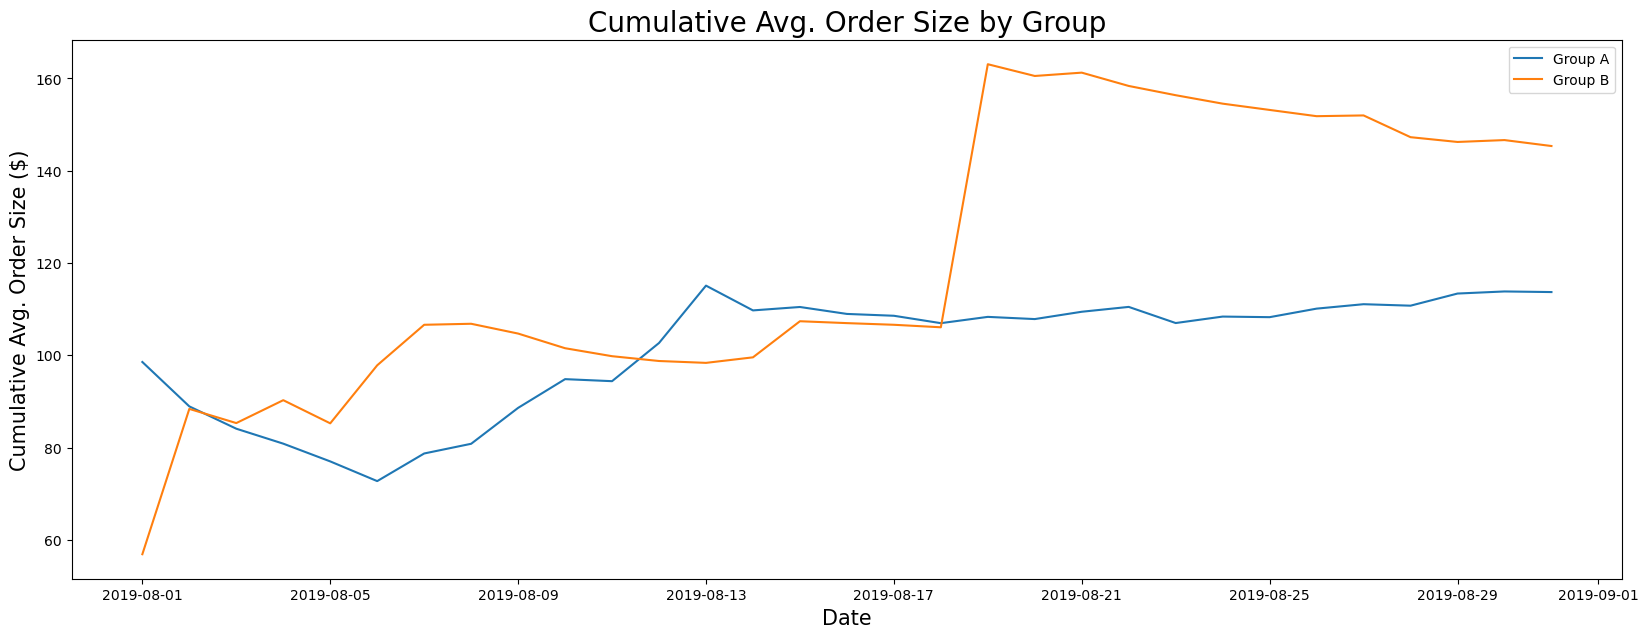

In [14]:
plt.figure(figsize = (20,7))
plt.plot(orders_A['date'], orders_A['cuml_avg_order_size'], label = 'Group A')
plt.plot(orders_B['date'], orders_B['cuml_avg_order_size'], label = 'Group B')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Cumulative Avg. Order Size ($)', fontsize = 15)
plt.title('Cumulative Avg. Order Size by Group', fontsize = 20)
plt.legend()
plt.show()

### Graph the relative difference in cumulative average order size for group B compared with group A.

In [15]:
orders_B ['cumulative_difference'] = orders_B['cuml_avg_order_size'] -orders_A['cuml_avg_order_size']

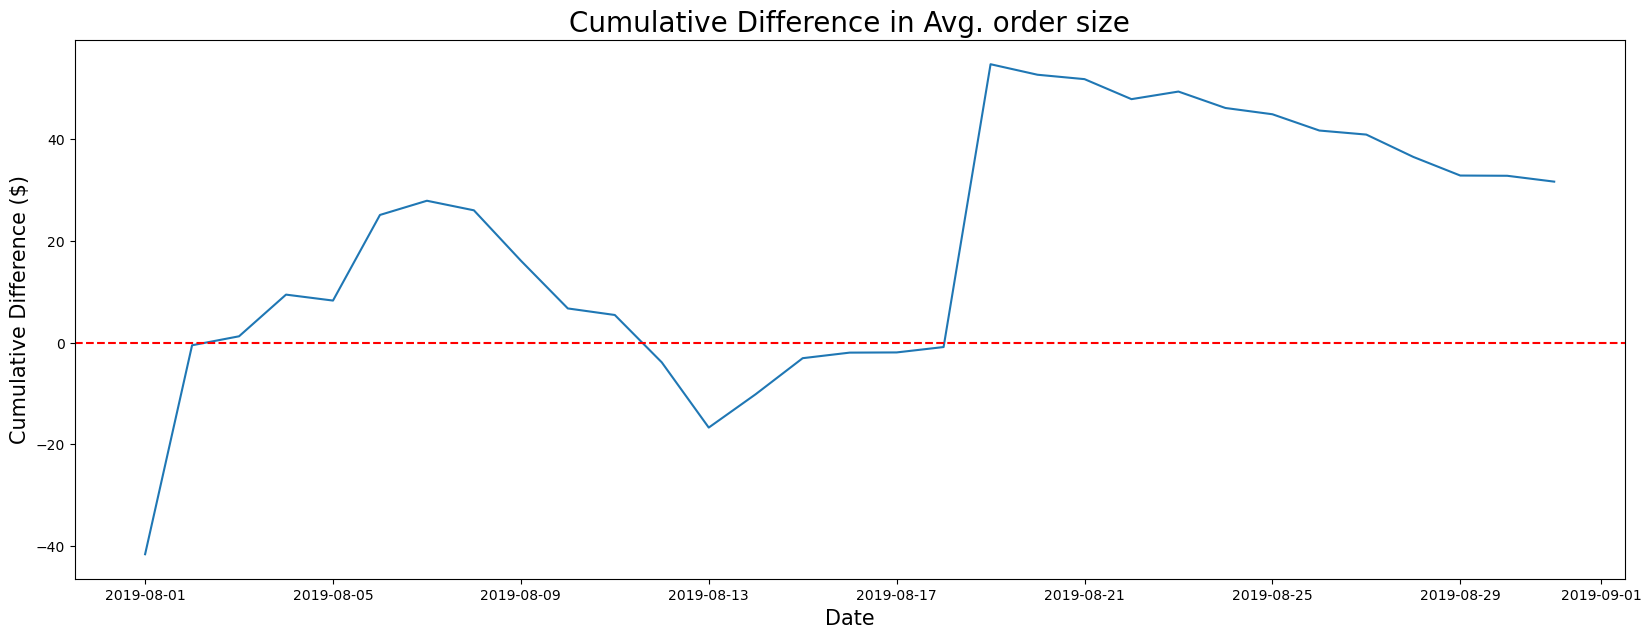

In [16]:
plt.figure(figsize = (20,7))
plt.plot(orders_A['date'], orders_B['cumulative_difference'])
plt.axhline(0, color ='r', linestyle = '--')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Cumulative Difference ($)', fontsize = 15)
plt.title('Cumulative Difference in Avg. order size', fontsize = 20)
plt.show()

#### conclusion:
    - We have subtacted the group_A avg. order size from group_B and ploted the result.
    - Negative values indicates group_A avg. order size is larger at that particular time.
    - There is a clear anomoly in Group B around the date 2019-08-18.
    - Appers to be an abnormally large order.

### Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference.

In [17]:
visits_A = visits[visits['group'] == 'A']
visits_B = visits[visits['group'] == 'B']

In [18]:
orders_A = pd.merge(orders_A, visits_A, on = 'date')
orders_B = pd.merge(orders_B, visits_B, on = 'date')

In [19]:
orders_A['cuml_visits']=orders_A['visits'].cumsum()
orders_B['cuml_visits']=orders_B['visits'].cumsum()

In [20]:
orders_A['CR'] = orders_A['cuml_orders']/orders_A['cuml_visits']
orders_B['CR'] = orders_B['cuml_orders']/orders_B['cuml_visits']

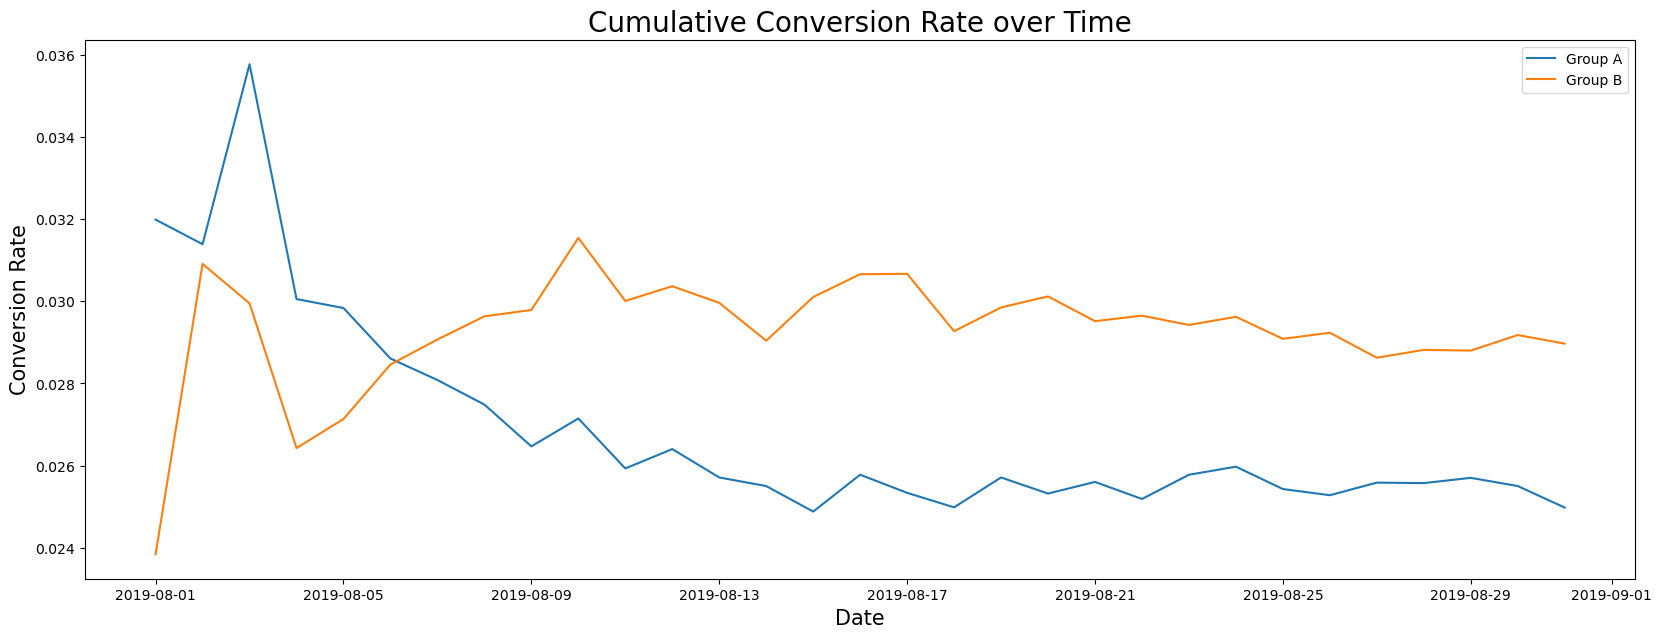

In [21]:
plt.figure(figsize = (20,7))
plt.plot(orders_A['date'], orders_A['CR'], label = 'Group A')
plt.plot(orders_B['date'], orders_B['CR'], label = 'Group B')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Conversion Rate', fontsize = 15)
plt.title('Cumulative Conversion Rate over Time', fontsize = 20)
plt.legend()
plt.show()

In [22]:
print( 'Group A overall Conversion Rate:', round(((orders_A['orders'].sum()/orders_A['visits'].sum())*100),1), '%')
print( 'Group B overall Conversion Rate:', round(((orders_B['orders'].sum()/orders_A['visits'].sum())*100),1), '%')

Group A overall Conversion Rate: 2.5 %
Group B overall Conversion Rate: 2.9 %


#### conclusion
    - Not a large obeservable difference in coversion rate.

### Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.

In [24]:
orders_per_user_A = orders[orders['group']=='A']
orders_per_user_A = orders_per_user_A.groupby('visitorId').agg({'group_count':'count'}).reset_index()
orders_per_user_A.columns = ['visitorId', 'order_count']
orders_per_user_A = orders_per_user_A.groupby('order_count').agg({'visitorId':'count'}).reset_index()

orders_per_user_B = orders[orders['group']=='B']
orders_per_user_B = orders_per_user_B.groupby('visitorId').agg({'group_count':'count'}).reset_index()
orders_per_user_B.columns = ['visitorId', 'order_count']
orders_per_user_B = orders_per_user_B.groupby('order_count').agg({'visitorId':'count'}).reset_index()

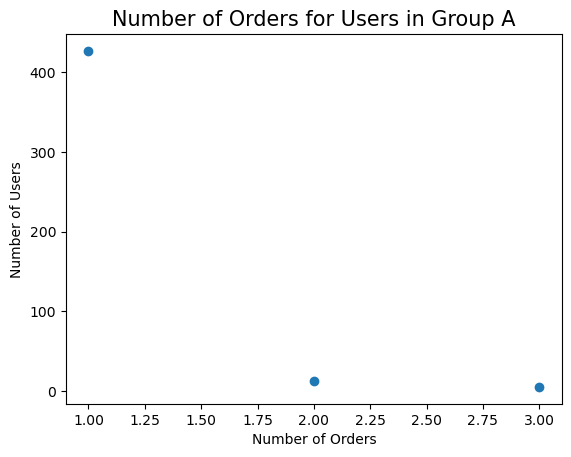

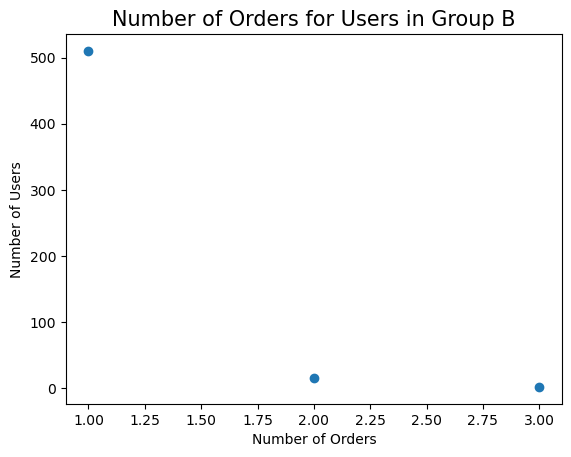

In [25]:
plt.scatter(orders_per_user_A['order_count'],
           orders_per_user_A['visitorId'])
plt.xlabel('Number of Orders', fontsize = 10)
plt.ylabel('Number of Users', fontsize = 10)
plt.title('Number of Orders for Users in Group A', fontsize = 15)
plt.show()

plt.scatter(orders_per_user_B['order_count'],
           orders_per_user_B['visitorId'])
plt.xlabel('Number of Orders', fontsize = 10)
plt.ylabel('Number of Users', fontsize = 10)
plt.title('Number of Orders for Users in Group B', fontsize = 15)
plt.show()

### Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

In [26]:
orders_A_ungrouped = orders[orders['group']=='A']
orders_B_ungrouped = orders[orders['group']=='B']

percentile_A_95 = orders_A_ungrouped.groupby('visitorId')['group'].count().quantile(.95)
percentile_A_99 = orders_A_ungrouped.groupby('visitorId')['group'].count().quantile(.99)

percentile_B_95 = orders_B_ungrouped.groupby('visitorId')['group'].count().quantile(.95)
percentile_B_99 = orders_B_ungrouped.groupby('visitorId')['group'].count().quantile(.99)

print('Group A 95 & 99 percentile:', percentile_A_95, ',', round(percentile_A_99,2))
print('Group B 95 & 99 percentile:', percentile_B_95, ',', round(percentile_B_99,2))

Group A 95 & 99 percentile: 1.0 , 2.56
Group B 95 & 99 percentile: 1.0 , 2.0


### Plot a scatter chart of order prices. Make conclusions and conjectures.

In [27]:
orders_revenue_A = orders[orders['group']=='A']
orders_revenue_B = orders[orders['group']=='B']

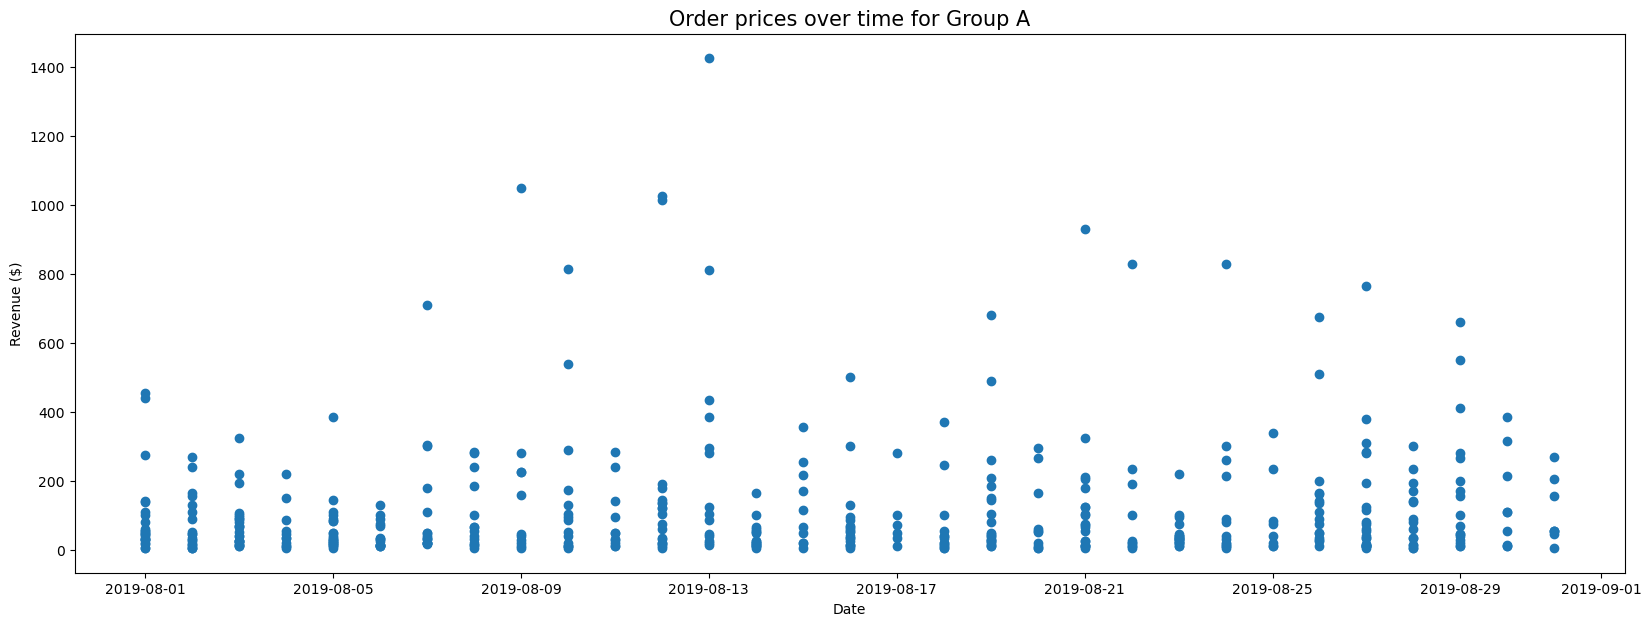

In [28]:
plt.figure(figsize=(20,7))
plt.scatter(orders_revenue_A['date'],
           orders_revenue_A['revenue'])
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Revenue ($)', fontsize = 10)
plt.title('Order prices over time for Group A', fontsize = 15)
plt.show()

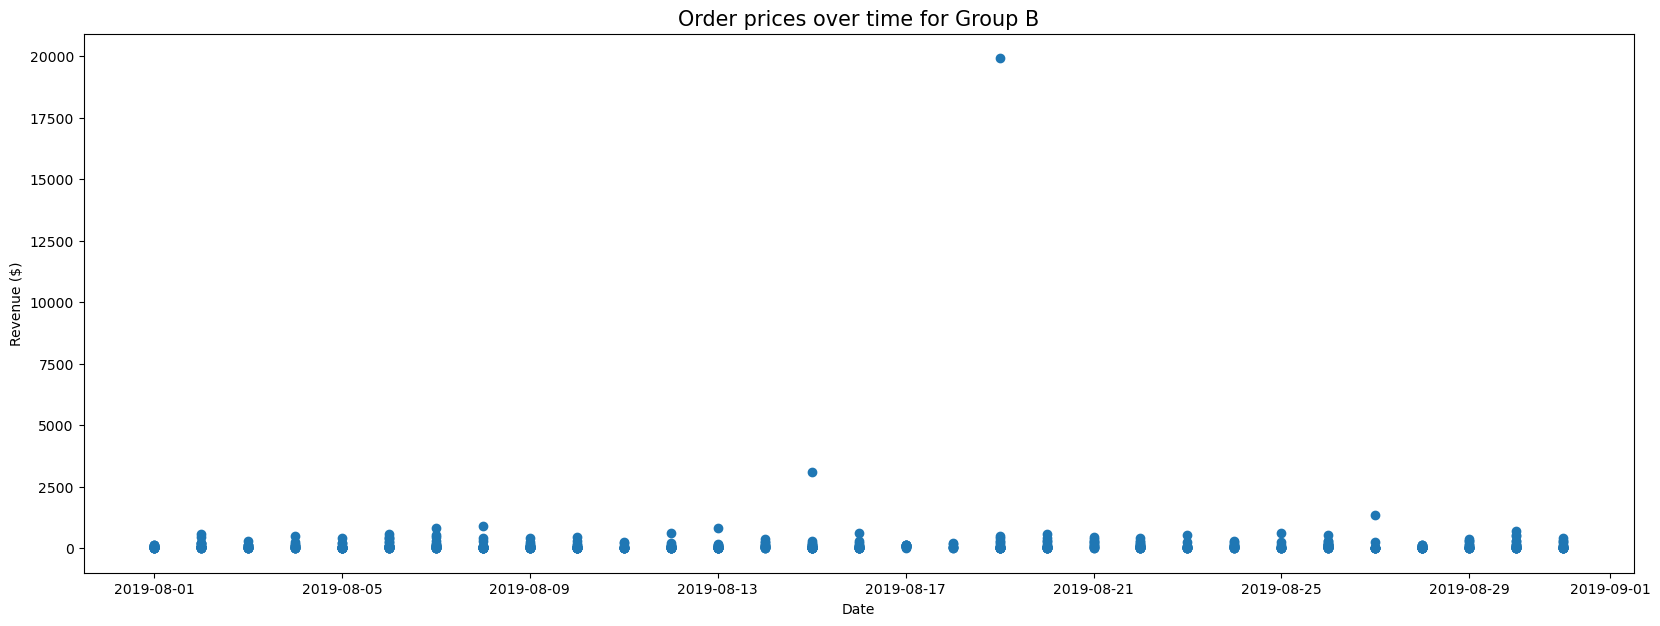

In [29]:
plt.figure(figsize=(20,7))
plt.scatter(orders_revenue_B['date'],
           orders_revenue_B['revenue'])
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Revenue ($)', fontsize = 10)
plt.title('Order prices over time for Group B', fontsize = 15)
plt.show()

#### conclusion:
    - There is a anomoly at 2019-08-19.
    - It is an abnormally large order.

### Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

In [30]:
print(np.percentile(orders_revenue_A['revenue'], [95,99]))
print(np.percentile(orders_revenue_B['revenue'], [95,99]))

[385.63  863.201]
[425.795 763.865]


#### conclusion
    - The anaomoly is at index 506.
    - There is an order placed for $19,920.4.

### Find the statistical significance of the difference in conversion between the groups using the raw data.

In [31]:
orders_A = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' :pd.Series.nunique})
orders_A.columns = ['visitorId', 'orders']

orders_B = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' :pd.Series.nunique})
orders_B.columns = ['visitorId', 'orders']

In [32]:
sample_A = pd.concat([orders_A['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(orders_A['orders'])), name='orders')],axis=0)

sample_B = pd.concat([orders_B['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(orders_B['orders'])), name='orders')],axis=0)


In [33]:
alpha = 0.05
results_CR = st.mannwhitneyu(sample_A, sample_B)

print('pvalue:',round(results_CR.pvalue,4))
print()

if (results_CR.pvalue > alpha):
    print('Failed to reject null hypothesis: we can not make conclusions about the difference.')
else:
    print('Null hypothesis rejected: the difference is statisticaly significant.')

pvalue: 0.011

Null hypothesis rejected: the difference is statisticaly significant.


#### conclusion
    - there is a difference in conversion rate for both groups.

### Find the statistical significance of the difference in average order size between the groups using the raw data. 

In [34]:
  sample_A = orders[orders['group']=='A']['revenue'] 
  sample_B = orders[orders['group']=='B']['revenue']

In [35]:
results_OS = st.mannwhitneyu(sample_A,sample_B)

print('pvalue:',round(results_OS.pvalue,4))
print()

if (results_OS.pvalue > alpha):
    print('Failed to reject null hypothesis: we can not make conclusions about the difference.')
else:
    print('Null hypothesis rejected: the difference is statisticaly significant.')

pvalue: 0.8622

Failed to reject null hypothesis: we can not make conclusions about the difference.


#### conclusion
    - No conclusions can be made about the difference in order_size for both groups.

### Find the statistical significance of the difference in conversion between the groups using the filtered data. 

In [36]:
users_many_orders = pd.concat([orders_A[orders_A['orders'] > 2]['visitorId'], orders_B[orders_B['orders'] > 2]['visitorId']], axis = 0)

users_expensive_orders = orders[orders['revenue'] > 900]['visitorId']

abnormal_users = pd.concat([users_many_orders,  users_expensive_orders], axis = 0).drop_duplicates().sort_values()


sampleA_filtered = pd.concat(
[
    orders_A[
        np.logical_not(orders_A['visitorId'].isin(abnormal_users))
    ]['orders'],
    pd.Series(
        0,
        index=np.arange(
            visits[visits['group'] == 'A']['visits'].sum()
            - len(orders_A['orders'])
        ),
        name='orders',
    ),
],
axis=0,)

In [37]:
sampleB_filtered = pd.concat(
[
    orders_B[
        np.logical_not(orders_B['visitorId'].isin(abnormal_users))
    ]['orders'],
    pd.Series(
        0,
        index=np.arange(
            visits[visits['group'] == 'B']['visits'].sum()
            - len(orders_B['orders'])
        ),
        name='orders',
    ),
],
axis=0,)

In [38]:
alpha = 0.05
results_CR_filtered = st.mannwhitneyu(sampleA_filtered,sampleB_filtered)

print('pvalue:',round(results_CR_filtered.pvalue,4))
print()

if (results_CR_filtered.pvalue > alpha):
    print('Failed to reject null hypothesis: we can not make conclusions about the difference.')
else:
    print('Null hypothesis rejected: the difference is statisticaly significant.')

pvalue: 0.007

Null hypothesis rejected: the difference is statisticaly significant.


#### conclusion
    - There is little change even after removing very expensive orders. We can conclude there is a difference between the    groups.

### Find the statistical significance of the difference in average order size between the groups using the filtered data.

<div class="alert alert-block alert-success"> <b>Reviewer's comment v3</b> <a 
class="tocSkip"></a>
    
Done
</div>

In [39]:
sampleA_filtered = orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue']
sampleB_filtered = orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue']

In [40]:
results_OS_filtered = st.mannwhitneyu(sampleA_filtered,sampleB_filtered)

print('pvalue:',round(results_OS_filtered.pvalue,4))
print()

if (results_OS_filtered.pvalue > alpha):
    print('Failed to reject null hypothesis: we can not make conclusions about the difference.')
else:
    print('Null hypothesis rejected: the difference is statisticaly significant.')

pvalue: 0.822

Failed to reject null hypothesis: we can not make conclusions about the difference.


#### conclusion:
    - pvalue decreases after removal of anomoly.
    - Null Hypothesis is rejected.     

### Make a decision based on the test results. 

#### conclusion:
    - Stop the test, consider one of the groups the leader.
    - Group B has higher conversion and order size compared to A.
    - Results after correcting for expensive orders, we got more accurate results.